In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA

import open_clip

from PIL import Image
import urllib.request
import os, math, gc, sys, json
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import filters
import argparse

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 读取预训练模型

In [3]:
def square_padding(image):
    w, h = image.size
    pad_w = max(0, (h - w) // 2)
    pad_h = max(0, (w - h) // 2)
    image = T.Pad((pad_w, pad_h))(image)
    return image

# md_name = 'ViT-bigG-14'
# pt_path = 'laion2b_s39b_b160k'

md_name = 'ViT-bigG-14'
pt_path = '/data1/code/yyg/image_retrival/yyg/open_clip_G_real/open_clip-G/open_clip/logs/epoch_5.pt'
model, _, image_preprocess = open_clip.create_model_and_transforms(model_name=md_name, pretrained=pt_path, device=device)
image_preprocess = T.Compose([T.Lambda(square_padding)]+image_preprocess.transforms)
hflip_image_preprocess = T.Compose([T.RandomHorizontalFlip(p=1)]+image_preprocess.transforms)
print(image_preprocess)
print(hflip_image_preprocess)

text_tokenizer = open_clip.get_tokenizer(md_name)

Compose(
    Lambda()
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f04b533d290>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Compose(
    RandomHorizontalFlip(p=1)
    Lambda()
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7f04b533d290>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


# 读取TOP50结果文件

In [4]:
def replace_prefix(sentence, prefixs):
    sentence_replaced = sentence
    for prefix in prefixs:
        if sentence.startswith(prefix):
            sentence_replaced = sentence.replace(prefix, "", 1)
    return sentence_replaced

In [5]:
# 定义一个函数，接受data和index作为参数
def read_json(data, index, part_num=50):
    # 从data中获取results列表
    results = data['results']
    # 判断index是否在results的范围内
    if 0 <= index < len(results):
        # 获取results中第index个元素，它是一个字典
        result = results[index]
        image_names = result['image_names'][:part_num]
        text = result['text']
        
        # 根据image_names判断是人还是车
        prefixs = ["A ", "This is a ", "An ", "This is an "]
        text = text.strip()[:-1]
        if image_names[0].startswith("vehicle_"):
            text = replace_prefix(text, prefixs)

        # 返回text和image_names
        return text, image_names
    else:
        # 如果index不在results的范围内，返回None
        return None

In [6]:
json_data_path = 'open_clip_infer-G-epoch5-top50.json'
with open(json_data_path) as f:
    data = json.load(f)

In [247]:
# index = 5516
# index = 51
# index = 7583 #重排序前就全不对 grey BYD Sedan
# index = 51 #把棕色和黑色的车踢了下去 grey BMW sedan
# index =6012 #重排序前就全不对 JAC MiniVAN
# index =2000 #重排序前就很多不对 blue Citroen Sedan
# index = 0 #重排序前就很多不对 grey Chery Sedan

# index = 9105
index = 10525
# index = 8005
# index = 12563
# index = 12641
img_path = '/home/yyg/image_retrival/data/datasets/test/test_images/'

In [248]:
len(data['results'])

17611

In [249]:
if index<7611:
    text, image = read_json(data, index, part_num=25)
else:
    text, image = read_json(data, index, part_num=15)
new_img_path = os.path.join(img_path, *map(str, image))
print(text)
print(image)

A pedestrian who is male is between 18 and 60 years old, with his body facing the camera and has a bag over the shoulder. He is in a shirt with short sleeves with an upper plaid
['094413.jpg', '099479.jpg', '090066.jpg', '098724.jpg', '096345.jpg', '091945.jpg', '096283.jpg', '091370.jpg', '094288.jpg', '094774.jpg', '099094.jpg', '098352.jpg', '099386.jpg', '097723.jpg', '090460.jpg']


# 属性筛选

## 汽车属性筛选

# 计算50x50相似度矩阵

In [250]:
topk = 10

In [251]:
class DecomcamAggregator():
    def __init__(self, n_components=1):
        self.pca = PCA(n_components=n_components)
        self.device = None
        
    def _to_1Darray(self, tensor):
        return tensor.detach().cpu().numpy()
    
    def _to_tensor(self, ndarray):
        return torch.from_numpy(ndarray)
    
    def _min_max_scale(self, alpha):
        return (alpha-alpha.min())/(alpha.max()-alpha.min())
    
    def get_aggregation_feature(self, alpha:torch.Tensor, features:torch.Tensor):
        '''
        alpha: [batch_size, 1]
        features: [batch_size, dim]
        '''
        self.device = alpha.device
        alpha = self._to_1Darray(alpha).T #[1, batch_sized], ndarray
        alpha = self._min_max_scale(alpha)
        
        features = self._to_1Darray(features).T #[dim, batch_size], ndarray
        agg_feature = -self.pca.fit_transform(alpha*features)
#         agg_feature = self.pca.fit_transform(features)
        return self._to_tensor(agg_feature).to(self.device)

In [252]:
# 定义一个空列表，用来存放预处理后的图片
images = []
images_hflip = []

# 图像预处理
for img_name in image:
    # 用os.path.join()方法合并img_path和img_name，得到完整的图片路径
    img_full_path = os.path.join(img_path, img_name)
    img = Image.open(img_full_path)
    images.append(image_preprocess(img))
    images_hflip.append(hflip_image_preprocess(img))

# 把images列表转换成一个张量，并在第一个维度上增加一个维度
images = torch.stack(images).to(device)
images = images.to(device)

images_hflip = torch.stack(images_hflip).to(device)
images_hflip = images_hflip.to(device)

texts = text_tokenizer([text]).to(device)
texts.shape, images.shape, images_hflip.shape

(torch.Size([1, 77]),
 torch.Size([15, 3, 224, 224]),
 torch.Size([15, 3, 224, 224]))

In [253]:
torch.max(torch.randn(4,5), torch.randn(4,5))

tensor([[ 0.3439,  1.6745,  0.8871,  0.5706, -0.3501],
        [-0.7545,  2.0892,  0.9396,  0.5511,  2.7389],
        [-0.0986,  0.5314,  1.4202, -0.4553,  0.1788],
        [-1.6867,  1.0330, -0.1587,  1.1459,  0.4749]])

In [254]:
aggre_num = topk//2

In [255]:
aggregator = DecomcamAggregator()
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(images)
    hflip_image_features = model.encode_image(images_hflip)
    
    text_features = model.encode_text(texts)
    txt_similarity_matrix = torch.cosine_similarity(text_features.unsqueeze(1), image_features, dim=-1)

# 不做跨域适应
    query_features = text_features
    
# 主成分平均
    query_features = aggregator.get_aggregation_feature(txt_similarity_matrix.T[:aggre_num], image_features[:aggre_num]).T



# #加权平均
#     alpha = (txt_similarity_matrix-txt_similarity_matrix.min())/(txt_similarity_matrix.max()-txt_similarity_matrix.min())
#     query_features = (alpha.T[:topk]*image_features[:topk]).mean(dim=0, keepdim=True)

# #不加权平均
#     query_features = image_features[:topk].mean(dim=0, keepdim=True)
    
    n_img_similarity_matrix = torch.cosine_similarity(image_features.unsqueeze(1), image_features, dim=-1)
    h_img_similarity_matrix = torch.cosine_similarity(image_features.unsqueeze(1), hflip_image_features, dim=-1)
    img_similarity_matrix = torch.max(n_img_similarity_matrix, h_img_similarity_matrix)
    
    n_qry_similarity_matrix = torch.cosine_similarity(query_features.unsqueeze(1), image_features, dim=-1)
    h_qry_similarity_matrix = torch.cosine_similarity(query_features.unsqueeze(1), hflip_image_features, dim=-1)
    qry_similarity_matrix = torch.max(n_qry_similarity_matrix, h_qry_similarity_matrix)
    
txt_similarity_matrix.shape, qry_similarity_matrix.shape, img_similarity_matrix.shape

(torch.Size([1, 15]), torch.Size([1, 15]), torch.Size([15, 15]))

In [256]:
print(f'''
txt_similarity_matrix:{txt_similarity_matrix}
qry_similarity_matrix:{qry_similarity_matrix}
n_qry_similarity_matrix:{n_qry_similarity_matrix}
h_qry_similarity_matrix:{h_qry_similarity_matrix}
''')


txt_similarity_matrix:tensor([[0.4221, 0.4175, 0.4156, 0.4139, 0.4085, 0.4093, 0.4070, 0.4097, 0.4068,
         0.4058, 0.4016, 0.4035, 0.4045, 0.4046, 0.4012]], device='cuda:0')
qry_similarity_matrix:tensor([[0.9872, 0.9503, 0.9566, 0.9175, 0.9201, 0.8940, 0.9140, 0.9425, 0.9167,
         0.9184, 0.9575, 0.9050, 0.8832, 0.9123, 0.9703]], device='cuda:0')
n_qry_similarity_matrix:tensor([[0.9872, 0.9503, 0.9566, 0.9170, 0.9201, 0.8940, 0.9140, 0.9425, 0.9167,
         0.9184, 0.9575, 0.9050, 0.8810, 0.9091, 0.9703]], device='cuda:0')
h_qry_similarity_matrix:tensor([[0.9830, 0.9468, 0.9508, 0.9175, 0.9194, 0.8893, 0.8969, 0.9399, 0.9125,
         0.9131, 0.9566, 0.9041, 0.8832, 0.9123, 0.9701]], device='cuda:0')



# 计算k-reciprocal相似度

In [257]:
def knn(idx, sm, topk):
    '''
    sm: similarity matrix, tensor
    '''
    sm_np = sm.detach().cpu().numpy()
    idx_topk_set = np.argsort(-sm_np, axis=1)[idx, :topk]
    return idx_topk_set.tolist()

def is_k_reciprocal(idx1, idx2, sm_img, sm_qry, topk, text=True):
    if text: 
        knn1 = knn(idx1, sm_img, topk)
        knn2 = knn(idx2, sm_qry, topk)
#         knn2 = knn(idx1, sm_img, topk)
    else:
        knn1 = knn(idx1, sm_img, topk)
        knn2 = knn(idx2, sm_img, topk)
    if idx2 in knn1 and idx1 in knn2:
        return True
    else:
        return False

## Quantified k-reciprocal

In [258]:
def get_topk_reciprocal_q_similarity(sm_img, sm_qry, topk=10):
    '''
    img_sm: similarity matrix, tensor
    '''
    #得到文本的topk相近图像
    knn_qry = knn(0, sm_qry, topk)
    common_knn_lst = []
    reciprocal_knn_lst = []
    for idx in range(len(sm_img)):
        #得到img_idx的topk相近图像
        knn_img = knn(idx, sm_img, topk)
        common_knn = len(set(knn_qry).intersection(set(knn_img))) + 2
        reciprocal_knn = len([p for p in knn_img if is_k_reciprocal(p, 0, sm_img, sm_qry, topk)])+\
                         len([p for p in knn_qry if is_k_reciprocal(p, idx, sm_img, sm_qry, topk, text=False)])+\
                         is_k_reciprocal(idx, 0, sm_img, sm_qry, topk) * 2
        
        common_knn_lst.append(common_knn)
        reciprocal_knn_lst.append(reciprocal_knn)
    common_knn_np = np.array(common_knn_lst)
    reciprocal_knn_np = np.array(reciprocal_knn_lst)
    sim_txt_np = sm_qry.detach().cpu().numpy().flatten()
    sim = sim_txt_np * (common_knn_np/(2*topk-common_knn_np))*(reciprocal_knn_np/(2*topk-reciprocal_knn_np))
    return sim

In [259]:
if index>=7611:
    sim = get_topk_reciprocal_q_similarity(img_similarity_matrix, qry_similarity_matrix, topk=10)
else:
#     sim = get_topk_reciprocal_q_ssimilarity(n_img_similarity_matrix, n_qry_similarity_matrix, topk=10)
    sim = get_topk_reciprocal_q_similarity(img_similarity_matrix, qry_similarity_matrix, topk=10)

sorted_a = [sim[np.argsort(-sim)],np.argsort(-sim)]

print(sorted_a[0]) # the sorted tensor
print(sorted_a[1]) # the original positions

[       inf        inf 8.61756957 8.60895109 8.48239589 5.20425647
 3.01128075 2.99998875 2.85101902 2.02920033 1.7449648  1.39413853
 1.11959525 0.9049859  0.58877126]
[ 0 14 10  2  7  9  4  8  1  5  6  3 13 11 12]


/home/yyg/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


## Embedded k-reciprocal
它使用了 k-reciprocal 特征向量来表示每个图像，而不是直接使用原始的特征向量。这样可以更好地捕捉探针图像和图库图像之间的相互关系，提高重排的准确性。
它使用了 Jaccard 距离来衡量探针图像和图库图像之间的差异，而不是直接使用余弦相似度。这样可以更好地考虑特征向量之间的重叠程度，降低噪声的影响。
它将原始的余弦相似度和 Jaccard 距离结合起来，得到一个新的相似度矩阵，并根据该矩阵对图库图像进行重排。这样可以综合利用两种距离度量的优势，提高重排的效果。

In [260]:
def get_topk_reciprocal_e_similarity(sm_img, sm_qry, img_features, qry_feature, topk=10):
    '''
    img_sm: similarity matrix, tensor
    '''
    #得到文本的topk相近图像
    knn_qry = knn(0, sm_qry, topk)
    hidden_dim = img_features.size(1)
    #创建一个空的张量，用来存放 k-reciprocal 特征向量
    k_reciprocal_features = torch.zeros(len(sm_img), hidden_dim).to(qry_feature.device)
    k_reciprocal_nums = []
    weights = []
    for idx in range(len(sm_img)):
        #得到img_idx的topk相近图像
        knn_img = knn(idx, sm_img, topk)
        #计算 k-reciprocal 最近邻的个数
        k_reciprocal_num = len([p for p in knn_img if is_k_reciprocal(p, 0, sm_img, sm_qry, topk)])+\
                         len([p for p in knn_qry if is_k_reciprocal(p, idx, sm_img, sm_qry, topk, text=False)])+\
                         is_k_reciprocal(idx, 0, sm_img, sm_qry, topk)
        k_reciprocal_nums.append(k_reciprocal_num)
        
        weight = sm_qry[0][knn_img] / sm_qry[0][knn_img].sum()
        weights.append(weight)
        
    for idx in range(len(sm_img)):
        k_reciprocal_num = k_reciprocal_nums[idx]
        weight = weights[idx]
        if k_reciprocal_num > 0:
            k_reciprocal_features[idx] = (k_reciprocal_num *\
                                          weight.unsqueeze(1) *\
                                          img_features[knn_img]
                                         ).sum(dim=0) #[topk, 1] * [topk, dim] -> [dim]
    #计算 Jaccard 距离，方法是使用集合交集和并集的比例作为距离度量
    #img_features: [gallery_num, dim]
    #k_reciprocal_features: [gallery_num, dim]print()
    jaccard_distance = 1 - torch.cosine_similarity(qry_feature.unsqueeze(0), k_reciprocal_features, dim=-1)
    #将原始余弦相似度和 Jaccard 距离结合起来，得到一个新的相似度矩阵，并根据该矩阵对图库图像进行重排
    sim = sm_qry.cpu() - jaccard_distance.cpu()
    return sim.numpy()[0]

In [261]:
if index>=7611:
    sim = get_topk_reciprocal_e_similarity(img_similarity_matrix, qry_similarity_matrix,image_features, query_features, topk=10)
else:
#     sim = get_topk_reciprocal_similarity(n_img_similarity_matrix, n_qry_similarity_matrix, topk=10)
    sim = get_topk_reciprocal_e_similarity(img_similarity_matrix, qry_similarity_matrix, image_features, query_features, topk=10)
# print(sim)
sorted_a = [sim[np.argsort(-sim)],np.argsort(-sim)]

print(sorted_a[0]) # the sorted tensor
print(sorted_a[1]) # the original positions

[0.9745834  0.9578686  0.9447965  0.9437078  0.9376614  0.9294865
 0.9066926  0.90516573 0.904765   0.90311235 0.9007274  0.8992638
 0.8920415  0.88100123 0.8703581 ]
[ 0 14 10  2  1  7  4  9  3  8  6 13 11  5 12]


# 可视化

## 重排序前

A pedestrian who is male is between 18 and 60 years old, with his body facing the camera and has a bag over the shoulder. He is in a shirt with short sleeves with an upper plaid


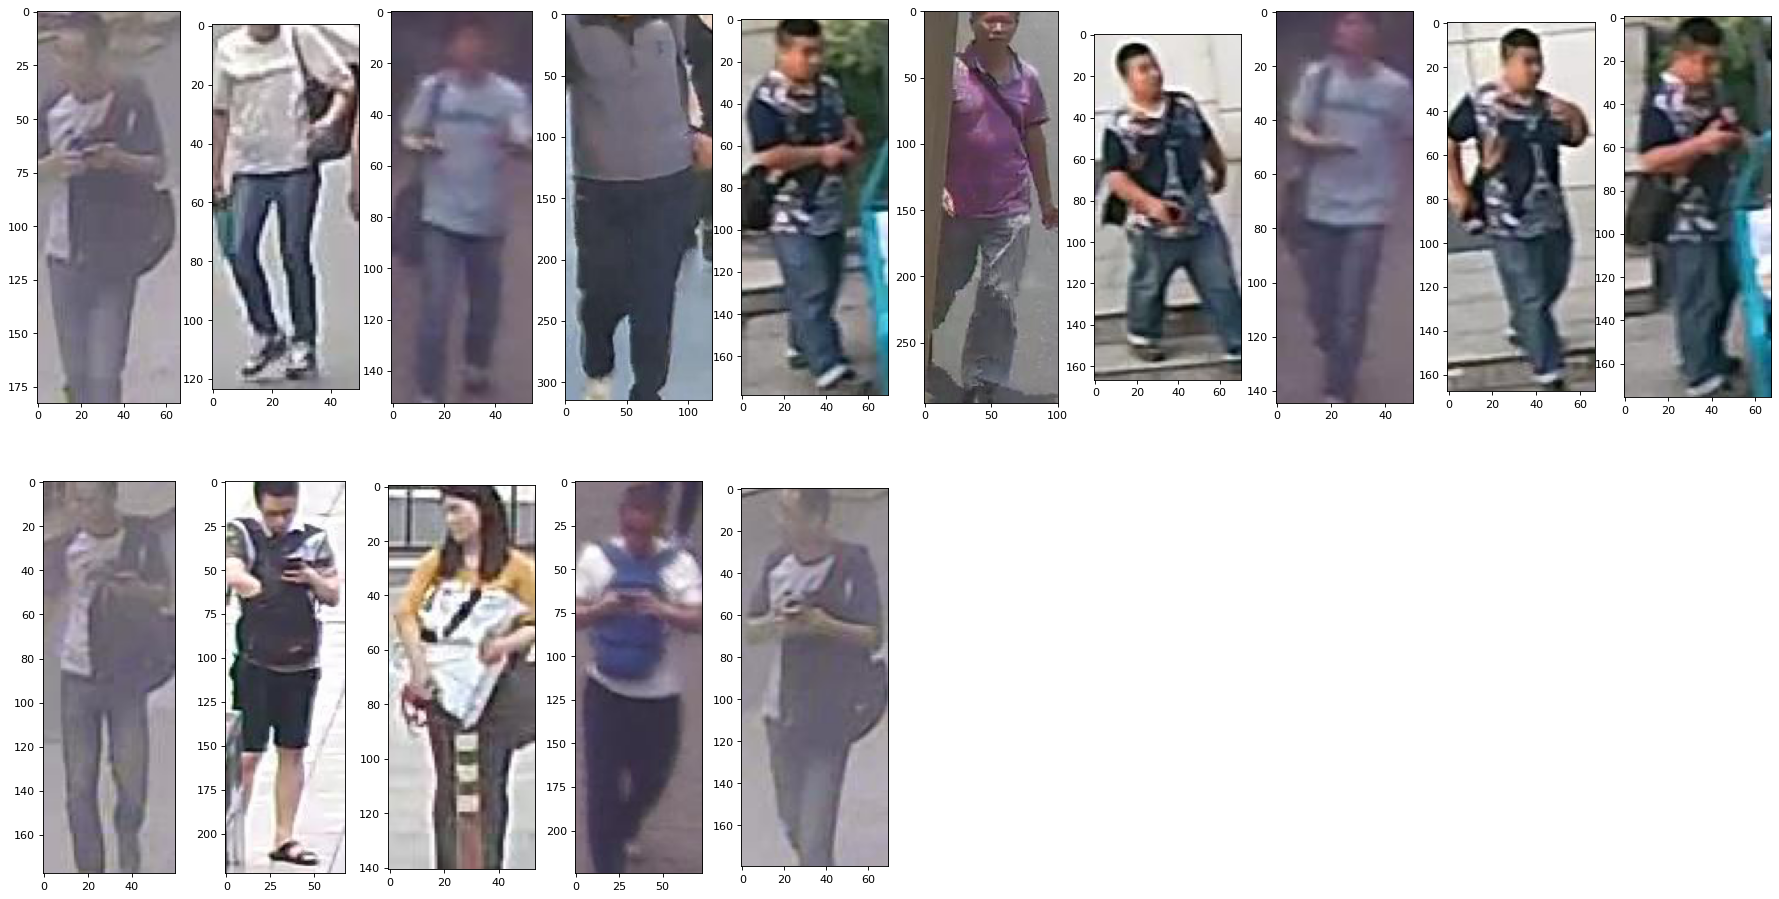

In [262]:
# 遍历new_img_path中的每个图片名字
if index>=7611:
    plt.figure(figsize=(28,14), dpi=80) 
else:
    plt.figure(figsize=(14,14), dpi=80) 
n = len(sorted_a[1]) # 获取图片的数量
for i, img_index in enumerate(range(n)):
    # 用os.path.join()方法合并img_path和img_name，得到完整的图片路径
    img_name = image[img_index]
    img_full_path = os.path.join(img_path, img_name)
#     print(img_full_path)
    # 用Image.open()方法打开图片
    img = Image.open(img_full_path)
    
    if index>=7611:
        ax = plt.subplot(n//10+1, 10,  i+1) # 将画板划分为1行n列，取第i+1个区域
    else:
        ax = plt.subplot(n//5, 5,  i+1) # 将画板划分为1行n列，取第i+1个区域
    
    plt.imshow(img) # 在子图上显示图片
print(text)
plt.show() # 显示画板

## 重排序后

A pedestrian who is male is between 18 and 60 years old, with his body facing the camera and has a bag over the shoulder. He is in a shirt with short sleeves with an upper plaid


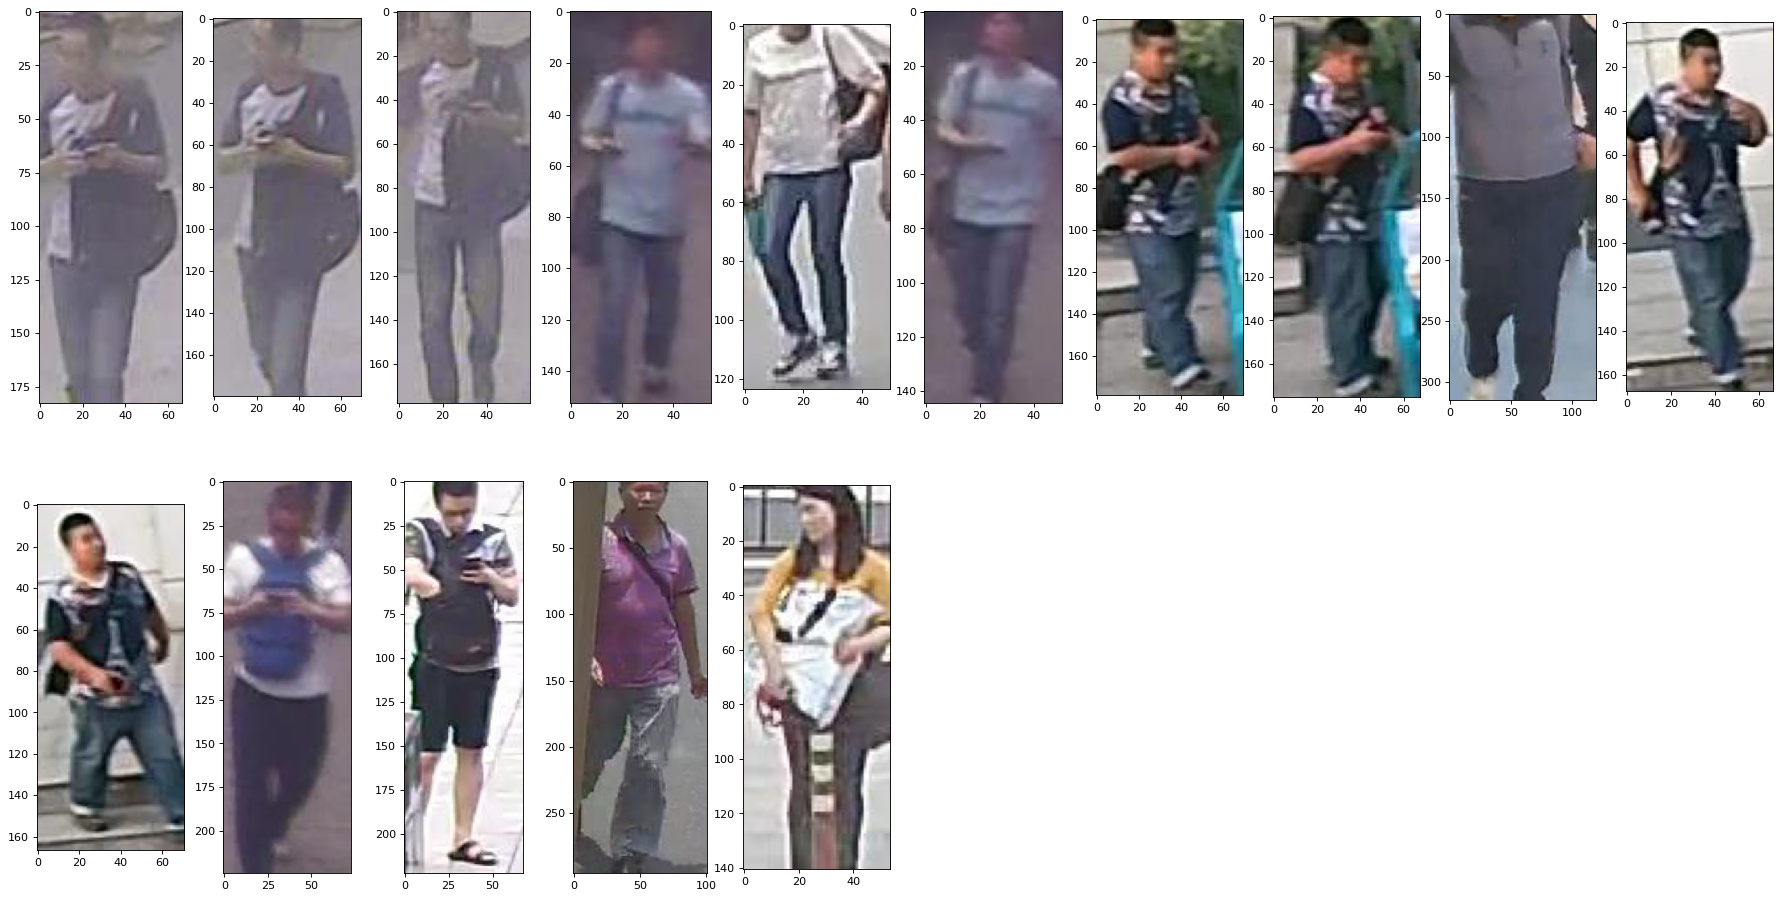

In [263]:
# 遍历new_img_path中的每个图片名字
if index>=7611:
    plt.figure(figsize=(28,14), dpi=80) 
else:
    plt.figure(figsize=(14,14), dpi=80) 
n = len(sorted_a[1]) # 获取图片的数量
for i, img_index in enumerate(sorted_a[1]):
    # 用os.path.join()方法合并img_path和img_name，得到完整的图片路径
    img_name = image[img_index]
    img_full_path = os.path.join(img_path, img_name)
#     print(img_full_path)
    # 用Image.open()方法打开图片
    img = Image.open(img_full_path)
    if index>=7611:
        ax = plt.subplot(n//10+1, 10,  i+1) # 将画板划分为1行n列，取第i+1个区域
    else:
        ax = plt.subplot(n//5, 5,  i+1) # 将画板划分为1行n列，取第i+1个区域
    plt.imshow(img) # 在子图上显示图片
print(text)
plt.show() # 显示画板

# 生成结果文件

In [10]:
json_data_path = 'open_clip_infer-G-epoch5-top50.json'
img_path = '/home/yyg/image_retrival/data/datasets/test/test_images/'
topk = 10
car_man_split_idx = 7611
car_part_num = 25
person_part_num = 50

In [11]:
with open(json_data_path) as f:
    data = json.load(f)

In [44]:
result_list = []
for index in tqdm(range(len(data['results']))[car_man_split_idx:car_man_split_idx+2]):
    if index<car_man_split_idx:
        text, image = read_json(data, index, part_num=car_part_num)
    else:
        text, image = read_json(data, index, part_num=person_part_num)
    text, image = read_json(data, index)
    new_img_path = os.path.join(img_path, *map(str, image))
    
    
    images = []
    images_hflip = []
    for img_name in image:
        img_full_path = os.path.join(img_path, img_name)
        img = Image.open(img_full_path)
        images.append(image_preprocess(img))
        images_hflip.append(hflip_image_preprocess(img))
    images = torch.stack(images).to(device)
    images = images.to(device)
    images_hflip = torch.stack(images_hflip).to(device)
    images_hflip = images_hflip.to(device)
    texts = text_tokenizer([text]).to(device)
    
    aggregator = DecomcamAggregator()
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(images)
        hflip_image_features = model.encode_image(images_hflip)

        text_features = model.encode_text(texts)
        txt_similarity_matrix = torch.cosine_similarity(text_features.unsqueeze(1), image_features, dim=-1)

        query_features = aggregator.get_aggregation_feature(txt_similarity_matrix.T[:topk], image_features[:topk]).T

        n_img_similarity_matrix = torch.cosine_similarity(image_features.unsqueeze(1), image_features, dim=-1)
        h_img_similarity_matrix = torch.cosine_similarity(image_features.unsqueeze(1), hflip_image_features, dim=-1)
        img_similarity_matrix = torch.max(n_img_similarity_matrix, h_img_similarity_matrix)

        n_qry_similarity_matrix = torch.cosine_similarity(query_features.unsqueeze(1), image_features, dim=-1)
        h_qry_similarity_matrix = torch.cosine_similarity(query_features.unsqueeze(1), hflip_image_features, dim=-1)
        qry_similarity_matrix = torch.max(n_qry_similarity_matrix, h_qry_similarity_matrix)
        
    sim = get_topk_reciprocal_e_similarity(img_similarity_matrix, qry_similarity_matrix, image_features, query_features, topk)
    sorted_a = [sim[np.argsort(-sim)],np.argsort(-sim)]
    
    dic = {'text': text, 'image_names': [image[img_idx] for img_idx in sorted_a[1][:50]]}
    result_list.append(dic)

with open(f"./rerank_result/open_clip_resoted_top50.json", 'w') as f:
    f.write(json.dumps({'results': result_list}, indent=4))

100%|█████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it]
